In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

import umap
import umap.plot
import scipy.io as sio
import hdbscan

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster
from scipy.spatial.distance import pdist

from datetime import datetime
from scipy.io import savemat

/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn

In [2]:
def iterative_pruning(X, labels, min_score_threshold=0.0, max_iters=10):
    """
    Iteratively prunes outliers in a 2D dataset (e.g., UMAP) based on silhouette scores.
    
    Parameters:
    - X: numpy array, shape (n_samples, 2)  # 2D UMAP data
    - labels: initial cluster labels for the data
    - min_score_threshold: float, minimum silhouette score threshold for pruning
    - max_iters: int, maximum number of pruning iterations

    Returns:
    - X_pruned: pruned data points
    - final_labels: cluster labels after pruning
    - silhouette_history: list of silhouette scores for each iteration
    """

    silhouette_history = []
    X_pruned = X.copy()
    labels_pruned = np.array(labels.copy())
    # labels_pruned = convert_strings_to_numbers(labels_pruned)

    for i in range(max_iters):
        # Calculate silhouette scores for each point
        silhouette_vals = silhouette_samples(X_pruned, labels_pruned)
        overall_silhouette = silhouette_score(X_pruned, labels_pruned)
        silhouette_history.append(overall_silhouette)

        # Identify points below the threshold to consider as outliers
        outliers = silhouette_vals < min_score_threshold
        # print(sum(outliers))
        if not np.any(outliers):
            print("No more points below threshold; stopping.")
            break

        # Remove outliers from the dataset
        X_pruned = X_pruned[~outliers]
        labels_pruned = labels_pruned[~outliers]
        
        # # Re-cluster remaining points
        # n_clusters = len(np.unique(labels_pruned))
        # kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        # labels_pruned = kmeans.fit_predict(X_pruned)

        # Calculate new silhouette score
        new_silhouette_score = silhouette_score(X_pruned, labels_pruned)
        print(f"Iteration {i+1}: Silhouette Score = {new_silhouette_score}")

        # Check for improvement
        if i > 0 and silhouette_history[-1] <= silhouette_history[-2]:
            print("Silhouette score did not improve; stopping.")
            break

    return X_pruned, labels_pruned, silhouette_history

# Example usage:
# Assuming `X_umap` is your 2D UMAP data and `initial_labels` are initial cluster labels
# X_umap, initial_labels = some_umap_and_clustering_function()
# X_pruned, final_labels, silhouette_history = iterative_pruning(X_umap, initial_labels)

# from collections import OrderedDict

# def convert_strings_to_numbers(A):
#     # Create an OrderedDict to maintain the order of first appearance
#     unique_strings = OrderedDict()
    
#     # Assign a unique integer to each unique string in the order of appearance
#     for string in A:
#         if string not in unique_strings:
#             unique_strings[string] = len(unique_strings) + 1
    
#     # Convert each string in A to its corresponding integer
#     numeric_list = [unique_strings[string] for string in A]
    
#     return numeric_list

In [3]:
data_path = '/media/user/teamshare/nick/behavior/grooming/2024-11-12-13-52-07_umap_test.mat'
mat_contents =  sio.loadmat(data_path)

In [4]:
# print(mat_contents['behavior_index'][0])

bFiles = np.array([x[0][0] for x in mat_contents['bFilepath']])
bIdx = np.array([x for x in mat_contents['behavior_index']])
labels = np.array([x[0][0] for x in mat_contents['behavior_label']])
fMat = np.array(mat_contents['featureMat'])
print(labels.shape)
print(bIdx.shape)
print(np.shape(fMat))

(5715,)
(5715, 2)
(5715, 44)


## The following cell shows input arguments for UMAP

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [5]:
# reducer = umap.UMAP(min_dist=0.1, n_components=2,n_neighbors=10,metric='correlation')
reducer = umap.UMAP(min_dist=0.0, n_components=2, n_neighbors=10, metric='euclidean', random_state=42)
reducer.fit(fMat)

/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.0, n_components=3, n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [6]:
embedding = reducer.transform(fMat)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(5715, 3)

In [9]:
reducer = umap.UMAP(min_dist=0.0, n_components=2, n_neighbors=10, metric='euclidean', random_state=42)
reducer.fit(fMat)

/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.0, n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [7]:
hover_data = pd.DataFrame({'behavior':labels,
                           'filePath':bFiles,
                           'frameStart':bIdx[:,0],
                           'frameEnd':bIdx[:,1]})

labelMap = hover_data.behavior.replace({
    'Elliptical':'0',
    'Right':'1',
    'Left':'2',
    'Right Asymmetric':'3',
    'Left Asymmetric':'4',
    'Elliptical Asymmetric':'5',
    'Large Bilateral':'6'
})

colorKey = dict(zip(labelMap, labelMap.map(
    {
        '0':'#1f77b4',
        '1':'#2ca02c',
        '2':'#d62728',
        '3':'#9467bd',
        '4':'#8c564b',
        '5':'#ff7f0e',
        '6':'#e377c2',
    }
)))

/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.3023819


ValueError: Plotting is currently only implemented for 2D embeddings

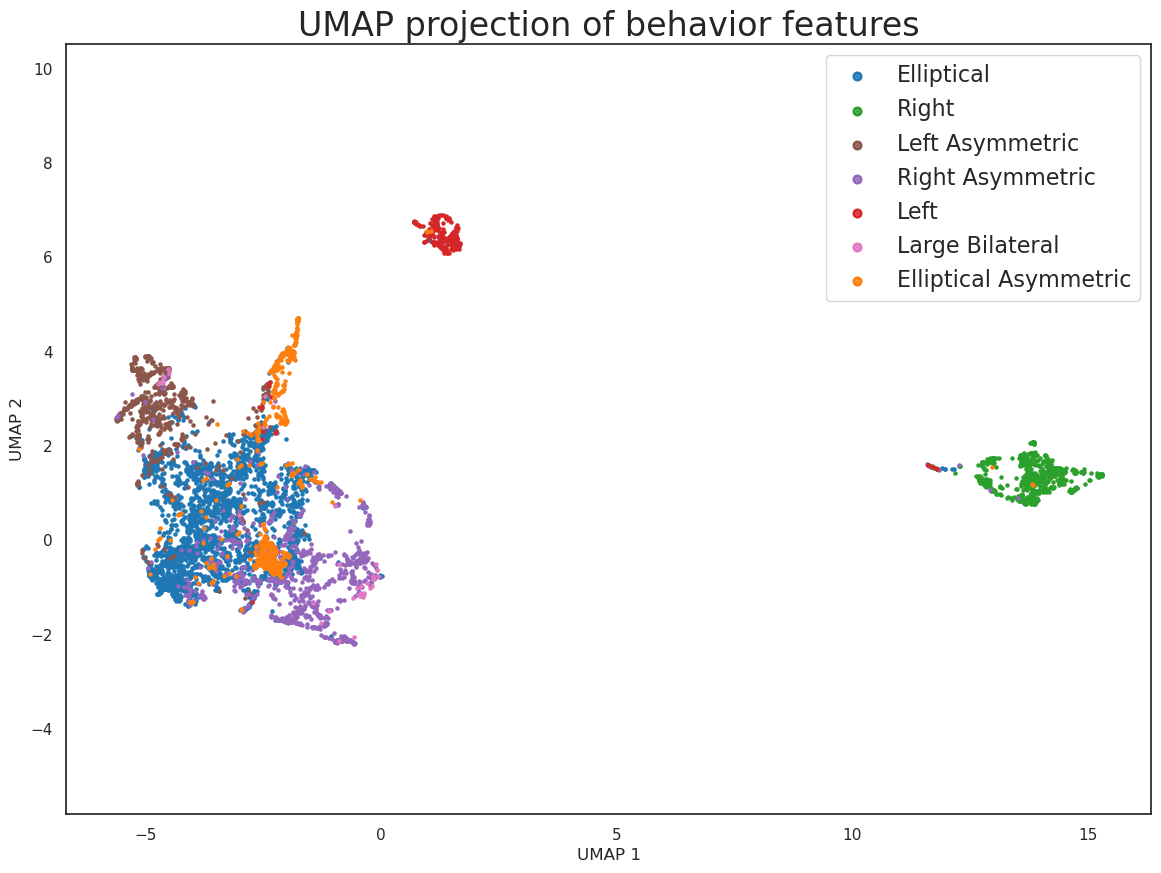

In [8]:
cols = []
for i,lab in enumerate(labels):
    if lab == "Elliptical":
        cols.append('#1f77b4')
    elif lab == "Elliptical Asymmetric":
        cols.append('#ff7f0e')
    elif lab == "Right":
        cols.append('#2ca02c')
    elif lab == "Left":
        cols.append('#d62728')
    elif lab == "Right Asymmetric":
        cols.append('#9467bd')
    elif lab == "Left Asymmetric":
        cols.append('#8c564b')
    elif lab == "Large Bilateral":
        cols.append('#e377c2')


test = np.unique(cols)

overall_silhouette = silhouette_score(embedding, labelMap)
print(overall_silhouette)

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
fig = plt.figure()
ax = fig.add_subplot()
for ii, col in enumerate(np.unique(cols)):
    idx = [True if test[ii] == i else False for i in cols]
    ax.scatter(embedding[idx,0], embedding[idx,1], c=col, s=5)

plt.title('UMAP projection of behavior features', fontsize=24);
leg = plt.legend(["Elliptical", "Right", "Left Asymmetric", "Right Asymmetric", "Left", "Large Bilateral", "Elliptical Asymmetric"],prop={'size': 16})
for legobj in leg.legend_handles:
    legobj.set_linewidth(5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.gca().set_aspect('equal', 'datalim')



p = umap.plot.interactive(reducer, labels=labelMap, hover_data=hover_data, point_size=5, color_key=colorKey)
p.title.text = "Silhouette: " + str(overall_silhouette)
umap.plot.show(p)

In [9]:
cols = []
for i,lab in enumerate(labels):
    if lab == "Elliptical":
        cols.append('#1f77b4')
    elif lab == "Elliptical Asymmetric":
        cols.append('#ff7f0e')
    elif lab == "Right":
        cols.append('#2ca02c')
    elif lab == "Left":
        cols.append('#d62728')
    elif lab == "Right Asymmetric":
        cols.append('#9467bd')
    elif lab == "Left Asymmetric":
        cols.append('#8c564b')
    elif lab == "Large Bilateral":
        cols.append('#e377c2')
    else:
        print(lab)
print(np.shape(cols))
print(labels.shape)
print(embedding.shape)

(5715,)
(5715,)
(5715, 2)


In [27]:
X_pruned, labels_pruned, silhouette_history = iterative_pruning(embedding, labels, min_score_threshold=0.0, max_iters=10)

Iteration 1: Silhouette Score = 0.5736876726150513
Iteration 2: Silhouette Score = 0.5745108723640442
No more points below threshold; stopping.


In [218]:
print(X_pruned.shape)
print(labels_pruned.shape)
print(np.unique(labels_pruned))

(3451, 2)
(3451,)
['Elliptical' 'Elliptical Asymmetric' 'Left' 'Left Asymmetric' 'Right'
 'Right Asymmetric']


Text(0, 0.5, 'UMAP 2')

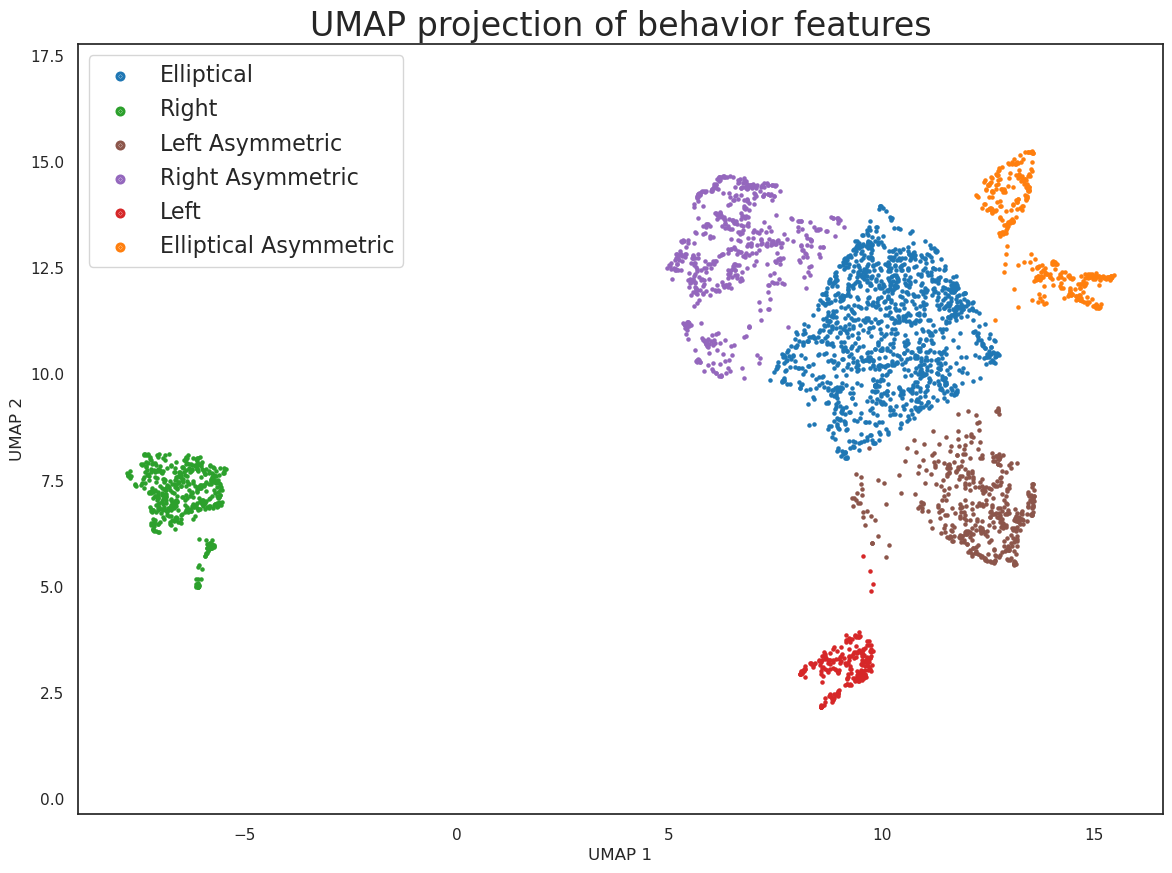

In [219]:
cols = []
for i,lab in enumerate(labels_pruned):
    if lab == "Elliptical":
        cols.append('#1f77b4')
    elif lab == "Elliptical Asymmetric":
        cols.append('#ff7f0e')
    elif lab == "Right":
        cols.append('#2ca02c')
    elif lab == "Left":
        cols.append('#d62728')
    elif lab == "Right Asymmetric":
        cols.append('#9467bd')
    elif lab == "Left Asymmetric":
        cols.append('#8c564b')
    elif lab == "Large Bilateral":
        cols.append('#e377c2')



fig = plt.figure()
ax = fig.add_subplot()
test = np.unique(cols)
for ii, col in enumerate(np.unique(cols)):
    idx = [True if test[ii] == i else False for i in cols]
    ax.scatter(X_pruned[idx,0], X_pruned[idx,1], c=col, s=5)


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of behavior features', fontsize=24);
leg = plt.legend(["Elliptical", "Right", "Left Asymmetric", "Right Asymmetric", "Left", "Elliptical Asymmetric"],prop={'size': 16})
for legobj in leg.legend_handles:
    legobj.set_linewidth(5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')


In [324]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels_kmeans = kmeans.fit_predict(embedding)

cols = []
for i,lab in enumerate(labels_kmeans):
    if lab == 0:
        cols.append('#1f77b4')
    elif lab == 1:
        cols.append('#ff7f0e')
    elif lab == 2:
        cols.append('#2ca02c')
    elif lab == 3:
        cols.append('#d62728')
    elif lab == 4:
        cols.append('#9467bd')
    elif lab == 5:
        cols.append('#8c564b')
    elif lab == 6:
        cols.append('#e377c2')

colorKey = dict(zip(labels_kmeans, cols))
    

p = umap.plot.interactive(reducer, labels=labels_kmeans, hover_data=hover_data, point_size=5, color_key=colorKey)
p.title.text = "Silhouette: " + str(overall_silhouette)
umap.plot.show(p)






/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


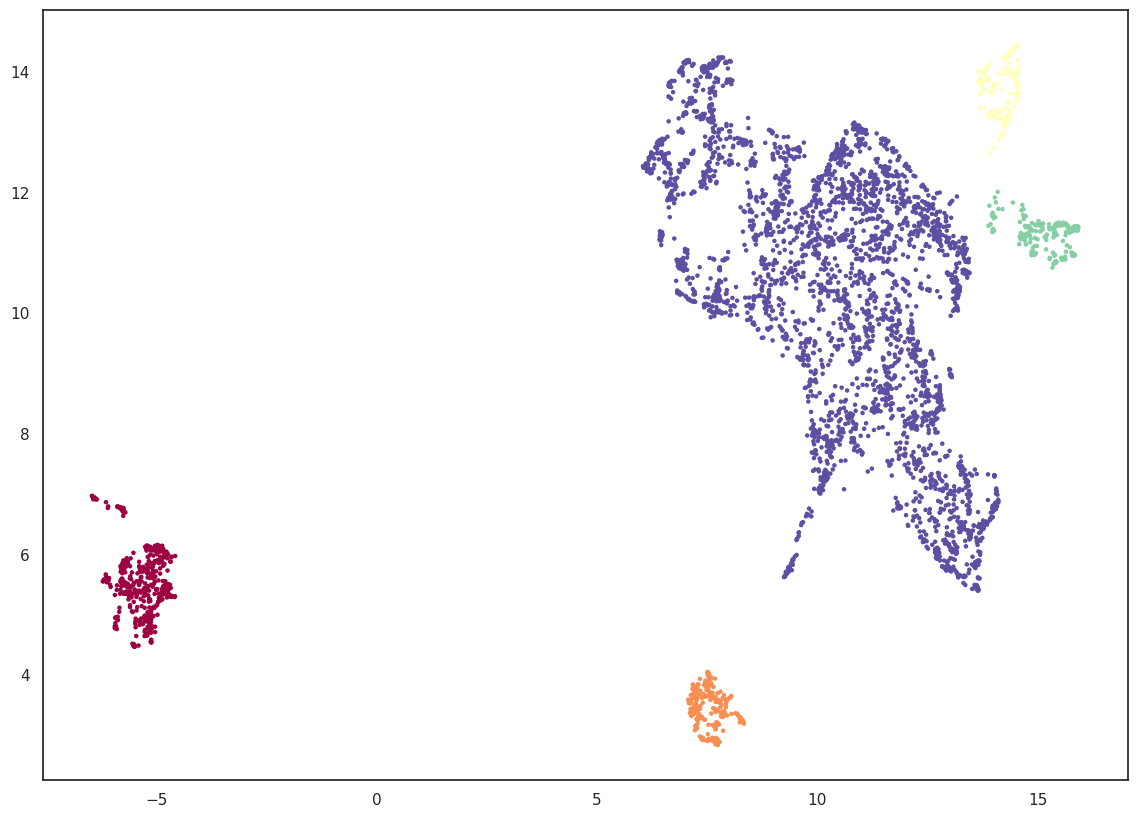

In [293]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(embedding)
clustered = (hdbscan_labels >= 0)
plt.scatter(embedding[~clustered, 0],
            embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=5,
            alpha=0.5)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=5,
            cmap='Spectral');

In [300]:
(
    adjusted_rand_score(labelMap[clustered], hdbscan_labels[clustered]),
    adjusted_mutual_info_score(labelMap[clustered], hdbscan_labels[clustered])
)

/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

(0.3798018012686711, 0.5792555983833179)

In [297]:
print(labelMap)

0       0
1       0
2       0
3       0
4       0
       ..
4428    3
4429    3
4430    3
4431    3
4432    3
Name: behavior, Length: 4433, dtype: object


In [27]:
from sklearn.mixture import GaussianMixture

Initialization 0
Initialization converged: True


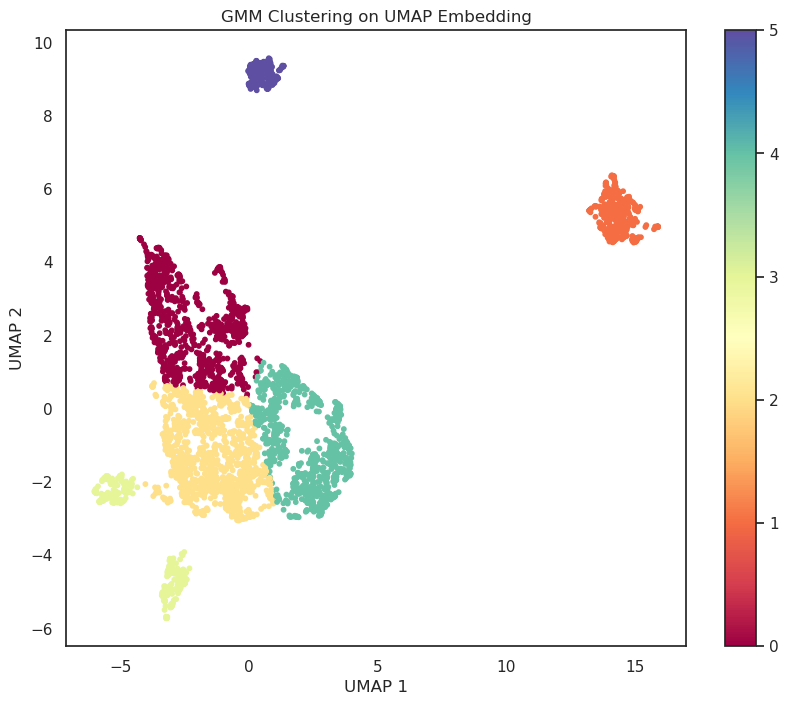

In [29]:
n_clusters = 6
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, verbose=1)
gmm.fit(embedding)

# Step 3: Predict cluster labels
gmm_labels = gmm.predict(embedding)
gmm_probs = gmm.predict_proba(embedding)
clustered = np.array([True if any(i>0.8) else False for i in gmm_probs])


# plt.figure(figsize=(10,8))
# plt.scatter(embedding[~clustered, 0],
#             embedding[~clustered, 1],
#             color=(0.5, 0.5, 0.5),
#             s=5,
#             alpha=0.5)
# plt.scatter(embedding[clustered, 0],
#             embedding[clustered, 1],
#             c=gmm_labels[clustered],
#             s=5,
#             cmap='Spectral');


# Step 4: Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=gmm_labels, cmap='Spectral', s=10)
plt.colorbar()
plt.title('GMM Clustering on UMAP Embedding')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [313]:
gmm_probs.shape

(4433, 6)

In [315]:
clustered = [True if any(i>0.5) else False for i in gmm_probs]


[True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True,

In [10]:
distance_matrix = pdist(embedding, metric='euclidean')
Z = linkage(distance_matrix, method='average')
num_clusters = 7
dend_labels = fcluster(Z, num_clusters, criterion='maxclust')

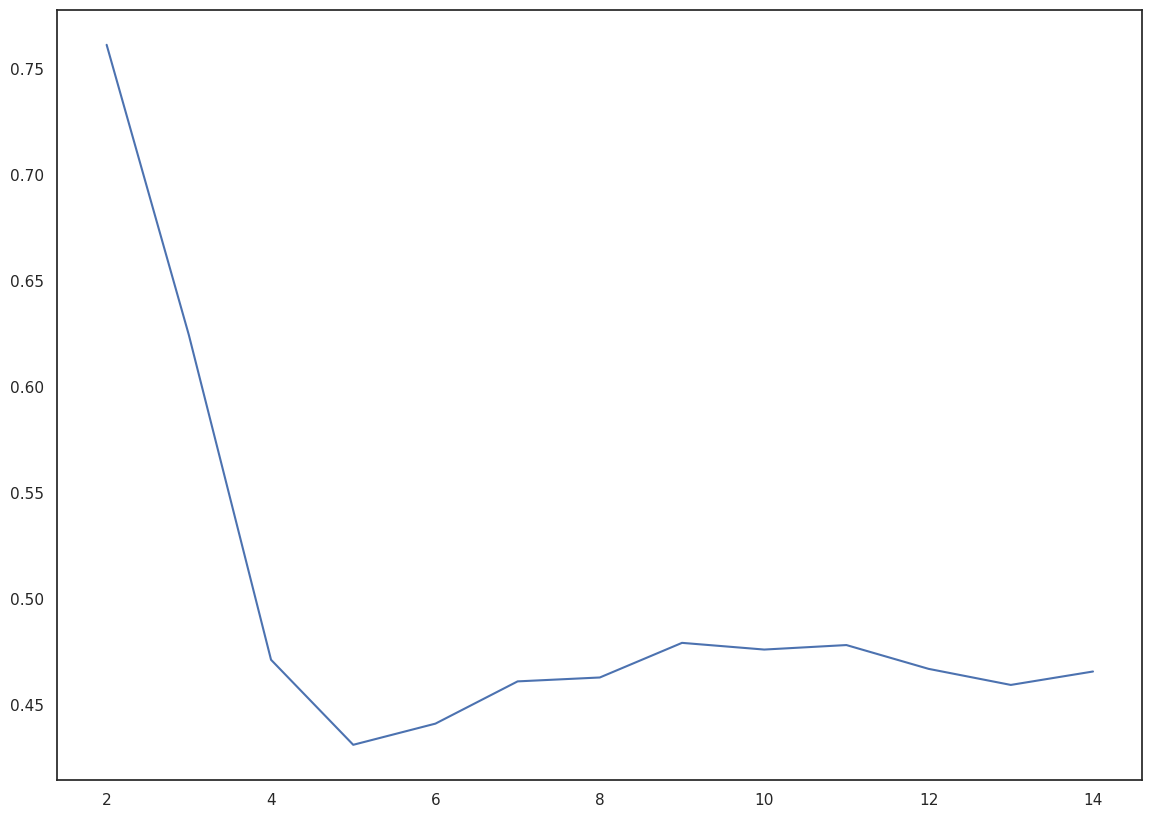

In [11]:
# from sklearn.metrics import pairwise_distances_argmin_min
x = []
overall_silhouette = []
for i in range(2,15,1):
    num_clusters = i 
    dend_labels = fcluster(Z, num_clusters, criterion='maxclust')
    overall_silhouette.append(silhouette_score(embedding, dend_labels))
    x.append(num_clusters)
    # distances = pairwise_distances_argmin_min(embedding, demd+

plt.figure()
plt.plot(x, overall_silhouette)
plt.show()

In [46]:
cols = []
for i,lab in enumerate(dend_labels):
    if lab == 1:
        cols.append('#1f77b4')
    elif lab == 2:
        cols.append('#ff7f0e')
    elif lab == 3:
        cols.append('#2ca02c')
    elif lab == 4:
        cols.append('#d62728')
    elif lab == 5:
        cols.append('#9467bd')
    elif lab == 6:
        cols.append('#8c564b')
    elif lab == 7:
        cols.append('#e377c2')
    elif lab == 8:
        cols.append('#7f7f7f')
    elif lab == 9:
        cols.append('#bcbd22')
    elif lab == 10:
        cols.append('#17becf')

colorKey = dict(zip(dend_labels, cols))

overall_silhouette = silhouette_score(embedding, dend_labels)
# print(overall_silhouette)

p = umap.plot.interactive(reducer, labels=dend_labels, hover_data=hover_data, point_size=5, color_key=colorKey)
p.title.text = "Silhouette: " + str(overall_silhouette)
umap.plot.show(p)


In [14]:
ARI = adjusted_rand_score(labelMap, dend_labels)
AMI = adjusted_mutual_info_score(labelMap, dend_labels)

/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/user/anaconda3/envs/nick/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

In [15]:
print(ARI)
print(AMI)

0.6757518105948215
0.6759143346979481


In [33]:
# distance_matrix = pdist(fMat, metric='euclidean')
# Z = linkage(distance_matrix, method='average')
# num_clusters = 6  # For example, if you want 6 clusters
# dend_labels = fcluster(Z, num_clusters, criterion='maxclust')

In [18]:
silhouette_vals = silhouette_samples(embedding, dend_labels)


In [19]:

time_now = datetime.today().strftime('%Y%m%d%H%M%S')
mdic = {"bFiles": bFiles, "dendrogram_labels": dend_labels, "manual_labels": labels, "bIdx":bIdx, "embedding":embedding, "ARI":ARI, "AMI":AMI, "silhouette_vals":silhouette_vals}
savemat(time_now + "_behavior_clustering.mat", mdic)

Iteration 1: Silhouette Score = 0.6182712316513062
No more points below threshold; stopping.


Text(0, 0.5, 'UMAP 2')

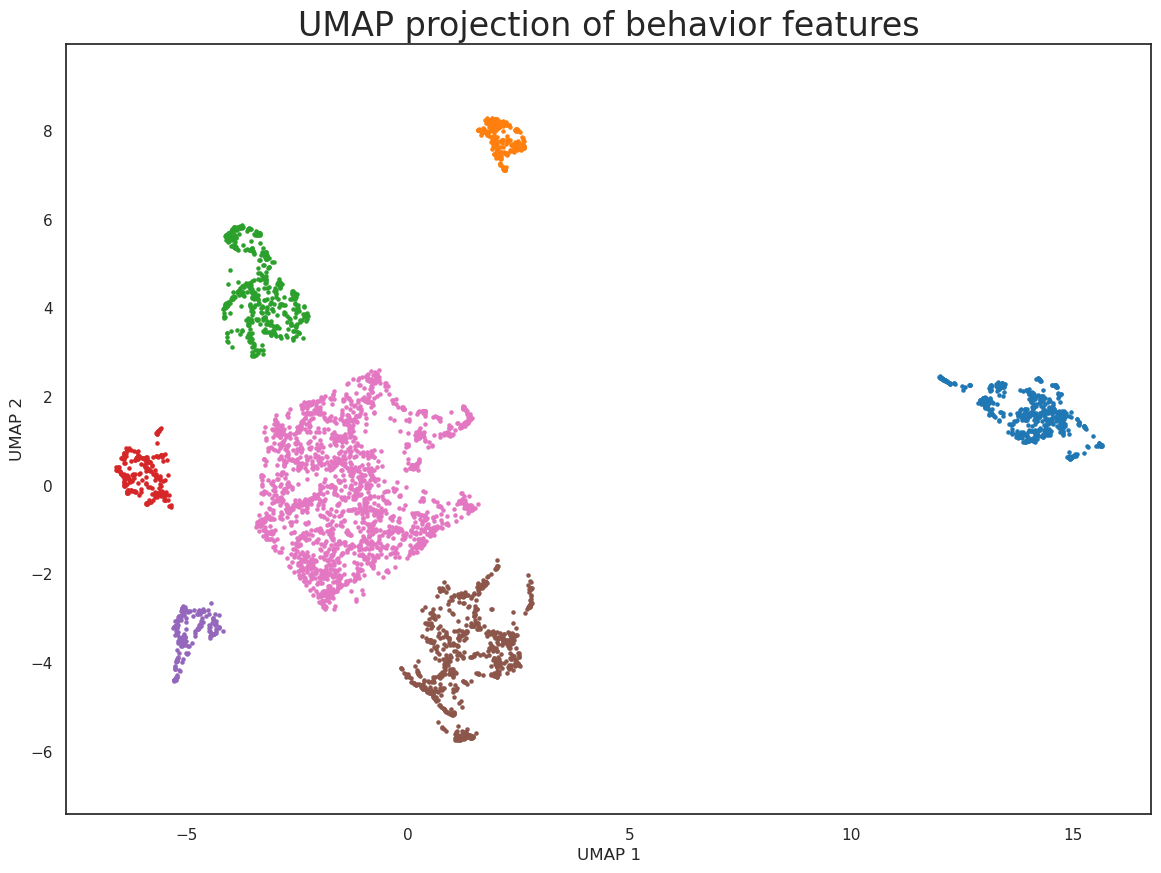

In [44]:
X_pruned, labels_pruned, silhouette_history = iterative_pruning(embedding, dend_labels, min_score_threshold=0.0, max_iters=10)
cols = []
for i,lab in enumerate(labels_pruned):
    if lab == 1:
        cols.append('#1f77b4')
    elif lab == 2:
        cols.append('#ff7f0e')
    elif lab == 3:
        cols.append('#2ca02c')
    elif lab == 4:
        cols.append('#d62728')
    elif lab == 5:
        cols.append('#9467bd')
    elif lab == 6:
        cols.append('#8c564b')
    elif lab == 7:
        cols.append('#e377c2')
    elif lab == 8:
        cols.append('#e372c2')


fig = plt.figure()
ax = fig.add_subplot()
test = np.unique(cols)
for ii, col in enumerate(np.unique(cols)):
    idx = [True if test[ii] == i else False for i in cols]
    ax.scatter(X_pruned[idx,0], X_pruned[idx,1], c=col, s=5)


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of behavior features', fontsize=24);
# leg = plt.legend(["Elliptical", "Right", "Left Asymmetric", "Right Asymmetric", "Left", "Elliptical Asymmetric"],prop={'size': 16})
for legobj in leg.legend_handles:
    legobj.set_linewidth(5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
